# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** Muhamad Fahmi Ammar
- **Email:** muh.fahmi.2001@gmail.com
- **ID Dicoding:** pamong_ammar

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

from google.colab import files
files.upload()


Saving kaggle (2).json to kaggle (2).json


{'kaggle (2).json': b'{"username":"pamongdev","key":"d4f823ab4a7f8a2970258f881670871c"}'}

## Import Semua Packages/Library yang Digunakan

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
!pip install scikeras[tensorflow]
!pip install scikeras[tensorflow-cpu]
# from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
import os
import shutil
import random
from PIL import Image
import cv2
from skimage.transform import rotate
from skimage.exposure import adjust_gamma
from skimage.transform import warp, AffineTransform
from skimage import io
import skimage
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 47.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2


In [3]:
args = {}
args['base_dir'] = '/content/data'
args['classes'] = ['dog', 'cat', 'wild']
args['batch_size'] = [32, 64]
args['epochs'] = [1,2]
args['learning_rate'] = [0.0001, 0.00001]


## Data Preparation

### Data Loading

In [4]:
# load from kaggle
!kaggle datasets download -d andrewmvd/animal-faces
!unzip animal-faces.zip




Streaming output truncated to the last 5000 lines.
  inflating: afhq/train/wild/flickr_wild_001378.jpg  
  inflating: afhq/train/wild/flickr_wild_001379.jpg  
  inflating: afhq/train/wild/flickr_wild_001380.jpg  
  inflating: afhq/train/wild/flickr_wild_001381.jpg  
  inflating: afhq/train/wild/flickr_wild_001382.jpg  
  inflating: afhq/train/wild/flickr_wild_001384.jpg  
  inflating: afhq/train/wild/flickr_wild_001385.jpg  
  inflating: afhq/train/wild/flickr_wild_001386.jpg  
  inflating: afhq/train/wild/flickr_wild_001387.jpg  
  inflating: afhq/train/wild/flickr_wild_001388.jpg  
  inflating: afhq/train/wild/flickr_wild_001389.jpg  
  inflating: afhq/train/wild/flickr_wild_001390.jpg  
  inflating: afhq/train/wild/flickr_wild_001391.jpg  
  inflating: afhq/train/wild/flickr_wild_001392.jpg  
  inflating: afhq/train/wild/flickr_wild_001393.jpg  
  inflating: afhq/train/wild/flickr_wild_001394.jpg  
  inflating: afhq/train/wild/flickr_wild_001395.jpg  
  inflating: afhq/train/wild/fl

In [5]:
# kumpulkan dalam satu folder
!mkdir data
!mkdir data/dog
!mkdir data/cat
!mkdir data/wild

source_dir = 'afhq'
destination_dir = 'data'

for tipe in os.listdir(source_dir) :
  tipe_dir = os.path.join(source_dir, tipe)
  for kelas in os.listdir(tipe_dir) :
    kelas_dir = os.path.join(tipe_dir, kelas)
    print(f"kelas {kelas} {tipe_dir}:",len(os.listdir(kelas_dir)))

for tipe in os.listdir(source_dir) :
  tipe_dir = os.path.join(source_dir, tipe)
  for kelas in os.listdir(tipe_dir) :
    kelas_dir = os.path.join(tipe_dir, kelas)
    for gambar in os.listdir(kelas_dir) :
      gambar_dir = os.path.join(kelas_dir, gambar)
      destination_dir_ = os.path.join(destination_dir, kelas, gambar)
      #menyalin gambar dari 'afhq' ke folder 'data'
      shutil.copy(gambar_dir, destination_dir_)

for cls in args['classes']:
  print(len(os.listdir(os.path.join(destination_dir, cls))))
# base dir-type-class

kelas cat afhq/train: 5153
kelas wild afhq/train: 4738
kelas dog afhq/train: 4739
kelas cat afhq/val: 500
kelas wild afhq/val: 500
kelas dog afhq/val: 500
5239
5653
5238


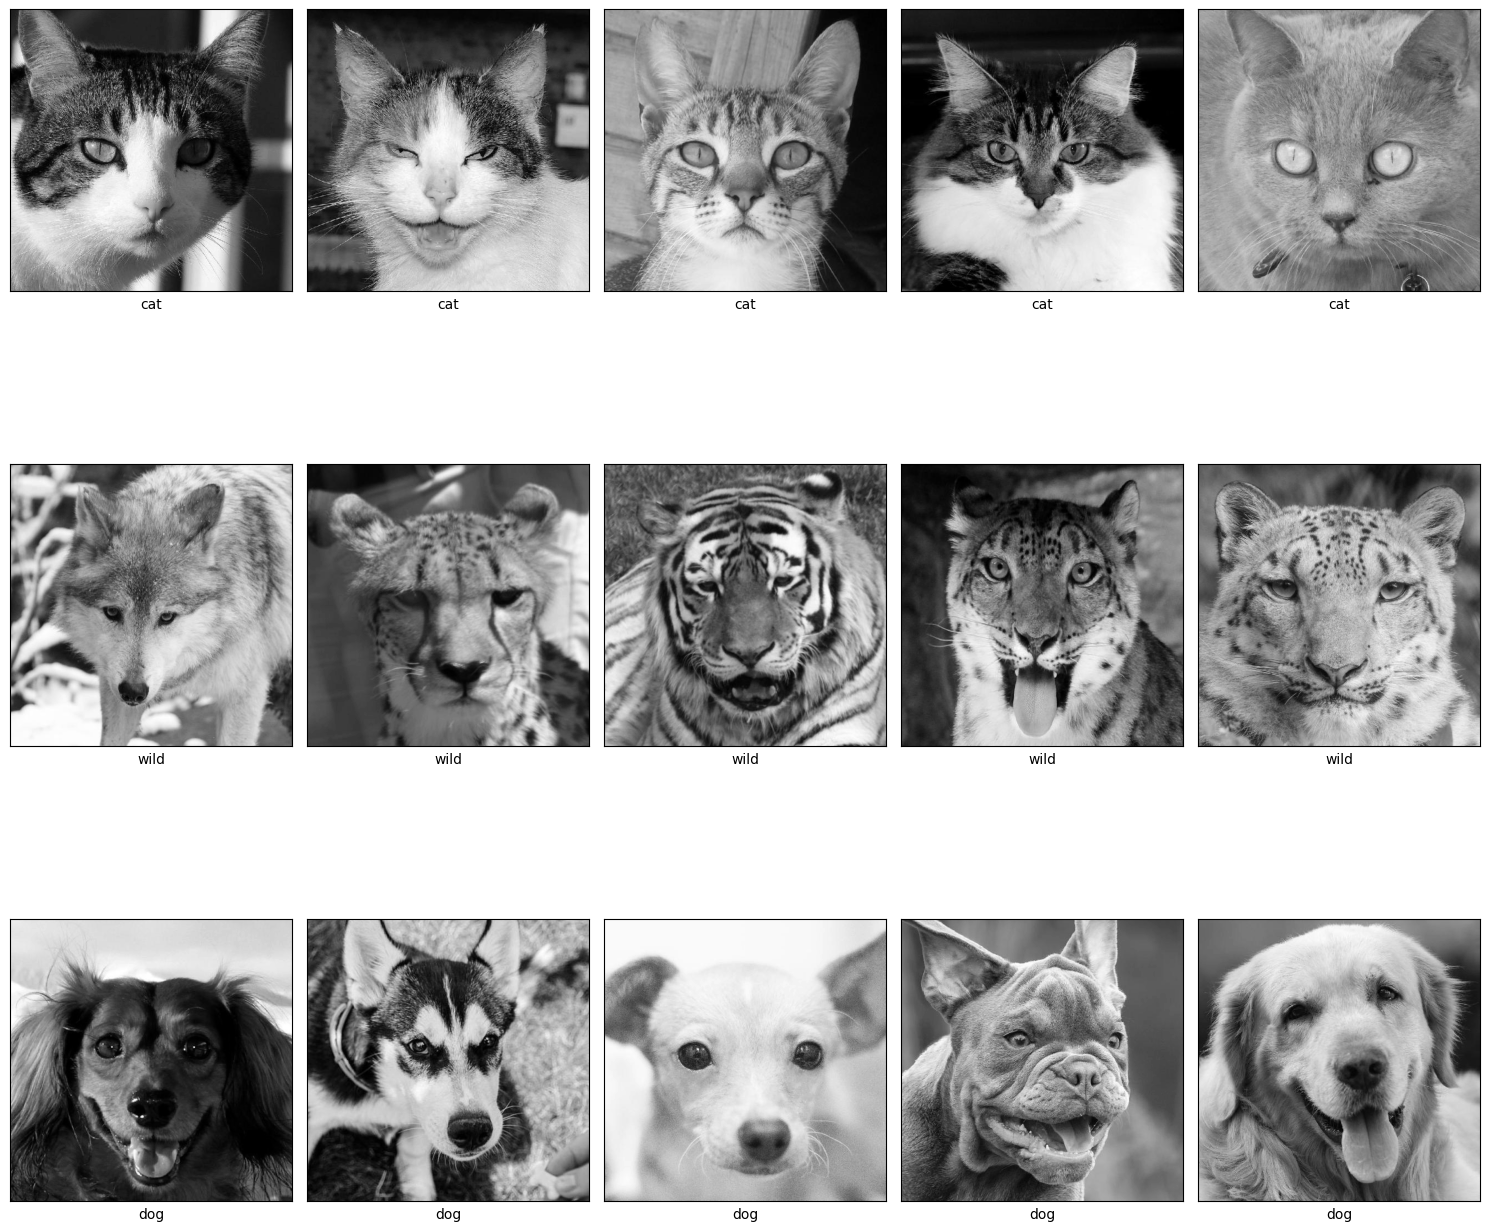

In [6]:
lung_image = {}


# Tentukan path sumber train
path = "data/"
path_sub = path
for class_name in os.listdir(path_sub):
    lung_image[class_name] = os.listdir(os.path.join(path_sub, class_name))

fig, axs = plt.subplots(len(lung_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(lung_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path).convert("L")  # Konversi menjadi skala keabuan
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

### Data Preprocessing


In [7]:
def anticlockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    sudut = random.randint(0,180)
    return rotate(img, sudut)

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    sudut = random.randint(0,180)
    return rotate(img, -sudut)

# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = cv2.cvtColor(img, 0)
    return np.flipud(img)

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    img = cv2.cvtColor(img, 0)
    img = adjust_gamma(img, gamma=0.5,gain=1)
    return img

# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    img = cv2.cvtColor(img, 0)
    return cv2.GaussianBlur(img, (9,9),0)

# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    img = cv2.cvtColor(img, 0)
    transform = AffineTransform(shear=0.2)
    shear_image = warp(img, transform, mode="wrap")
    return shear_image

# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    img = cv2.cvtColor(img, 0)
    transform = AffineTransform(translation=(0,40))
    warp_image = warp(img, transform, mode="wrap")
    return warp_image

In [8]:
transformations = { 'rotate anticlockwise': anticlockwise_rotation,
                    'rotate clockwise': clockwise_rotation,
                    'warp shift': warp_shift,
                    'blurring image': blur_image,
                    'add brightness' : add_brightness,
                    'flip up down': flip_up_down,
                    'shear image': sheared
                  }

dir_path_1 = 'data/dog'
dir_path_2 = 'data/wild'

target = 300

def augment_data(file_dir, target, transform_dict = transformations):
    images = []
    for im in os.listdir(file_dir):
      images.append(os.path.join(file_dir,im))
    i=1

    while i<=target:
        image=random.choice(images)
        try:
            original_image = io.imread(image)
            transformed_image=None
            n = 0      # Variabel untuk melakukan iterasi sampai jumlah transformasi yang akan diterapkan
            transformation_count = random.randint(1, len(transform_dict)) # Pilih jumlah transformasi acak yang akan diterapkan pada gambar

            while n <= transformation_count:
                key = random.choice(list(transform_dict)) # Secara acak memilih dan memanggil metode
                transformed_image = transformations[key](original_image)
                n = n + 1

            new_image_path= "%s/augmented_image_%s.jpg" %(file_dir, i)
            transformed_image = img_as_ubyte(transformed_image)  # Mengonversi gambar ke format byte yang tidak ditandatangani, dengan nilai dalam [0, 255]
            cv2.imwrite(new_image_path, transformed_image)  # Simpan hasil transformasi augmentasi pada gambar ke path yang ditentukan
            i =i+1
        except ValueError as e:
            print('could not read the',image ,':',e,'hence skipping it.')


In [9]:
augment_data(dir_path_1, target)
augment_data(dir_path_2, target)

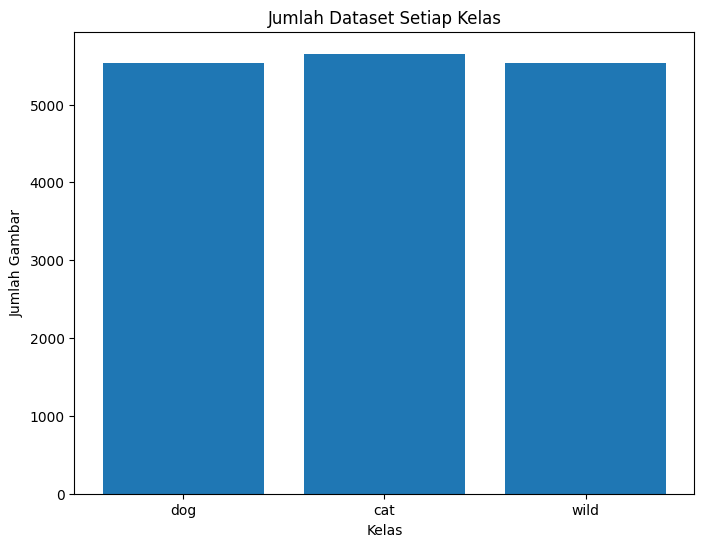

In [10]:
# prompt: membuat diagram batang dari jumlah dataset setiap kelas

import matplotlib.pyplot as plt

# Mendapatkan jumlah gambar dalam setiap kelas
class_counts = {}
for cls in args['classes']:
  class_counts[cls] = len(os.listdir(os.path.join(args['base_dir'], cls)))

# Membuat diagram batang
plt.figure(figsize=(8, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.title('Jumlah Dataset Setiap Kelas')
plt.show()


#### Split Dataset

In [11]:
#splitting dataset
df = {
    'path': [],
    'filename' : [],
    'label': []
}

for cls in args['classes']:
  for img in os.listdir(os.path.join(args['base_dir'], cls)):
    df['path'].append(os.path.join(args['base_dir'], cls, img))
    df['filename'].append(img)
    df['label'].append(cls)

df = pd.DataFrame(df)
df.head()

,path,filename,label
0,/content/data/dog/pixabay_dog_000935.jpg,pixabay_dog_000935.jpg,dog
1,/content/data/dog/pixabay_dog_001569.jpg,pixabay_dog_001569.jpg,dog
2,/content/data/dog/pixabay_dog_002455.jpg,pixabay_dog_002455.jpg,dog
3,/content/data/dog/pixabay_dog_001713.jpg,pixabay_dog_001713.jpg,dog
4,/content/data/dog/flickr_dog_000638.jpg,flickr_dog_000638.jpg,dog


In [12]:
df.groupby('label').count()

,path,filename
label,,
cat,5653,5653
dog,5539,5539
wild,5538,5538


In [13]:
X_train, X_test, y_train, y_test = train_test_split(df['path'], df['label'], test_size=0.2, random_state=42)

In [14]:
!mkdir dataset
!mkdir dataset/train
!mkdir dataset/train/dog
!mkdir dataset/train/cat
!mkdir dataset/train/wild
!mkdir dataset/test
!mkdir dataset/test/dog
!mkdir dataset/test/cat
!mkdir dataset/test/wild

In [15]:
destination_path = 'dataset'

for pathfile in X_train:
  destination_dir = os.path.join(destination_path, 'train', pathfile.split('/')[-2])
  shutil.copy(pathfile, destination_dir)

for pathfile in X_test:
  destination_dir = os.path.join(destination_path, 'test', pathfile.split('/')[-2])
  shutil.copy(pathfile, destination_dir)

In [16]:
print("Jumlah data latih: ", len(os.listdir(os.path.join(destination_path, 'train', 'cat'))))
print("Jumlah data latih: ", len(os.listdir(os.path.join(destination_path, 'train', 'dog'))))
print("Jumlah data latih: ", len(os.listdir(os.path.join(destination_path, 'train', 'wild'))))
print("Jumlah data uji: ", len(os.listdir(os.path.join(destination_path, 'test', 'cat'))))
print("Jumlah data uji: ", len(os.listdir(os.path.join(destination_path, 'test', 'dog'))))
print("Jumlah data uji: ", len(os.listdir(os.path.join(destination_path, 'test', 'wild'))))

Jumlah data latih:  4496
Jumlah data latih:  4437
Jumlah data latih:  4451
Jumlah data uji:  1157
Jumlah data uji:  1102
Jumlah data uji:  1087


In [17]:
TRAIN_PATH = 'dataset/train'
TEST_PATH = 'dataset/test'
ImageGenerator = ImageDataGenerator(rescale=1./255)

train_generator = ImageGenerator.flow_from_directory(
    target_size=(256,256),
    directory=TRAIN_PATH,
    batch_size=32,
    class_mode='categorical',
    shuffle=True
    )

test_generator = ImageGenerator.flow_from_directory(
    target_size=(256,256),
    directory=TEST_PATH,
    batch_size=32,
    class_mode='categorical',
    shuffle=False
    )


Found 13384 images belonging to 3 classes.
Found 3346 images belonging to 3 classes.


In [18]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.96 and logs.get('val_accuracy')>0.96):
      print("\nAkurasi telah mencapai >96%!")
      self.model.stop_training = True




## Modelling

In [19]:
# make model

def create_model(lr=0.001, optimizers = 'rmsprop'):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (4, 4), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (5, 5), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))

    if optimizers == 'adam':
        optimizers = tf.keras.optimizers.Adam(learning_rate=lr)
    elif optimizers == 'rmsprop':
        optimizers = tf.keras.optimizers.RMSprop(learning_rate=lr)
    model.compile(optimizer=optimizers,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [20]:
create_model().summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 254, 254, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 124, 124, 64)        │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 124, 124, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 58, 58, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 58, 58, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 29, 29, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 107648)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      13,779,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,027,075 (53.51 MB)

 Trainable params: 14,026,627 (53.51 MB)

 Non-trainable params: 448 (1.75 KB)

In [21]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
gpus = tf.config.experimental.list_physical_devices('GPU')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

with tf.device('/GPU:0'):

  model = create_model()

  # Membuat objek GridSearchCV
  history = model.fit(
      train_generator,
      epochs = 20,
      batch_size = 32,
      validation_data = test_generator,
      callbacks = [reduce_lr]
  )



Physical devices cannot be modified after being initialized
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


419/419 ━━━━━━━━━━━━━━━━━━━━ 87s 160ms/step - accuracy: 0.6288 - loss: 9.5321 - val_accuracy: 0.7355 - val_loss: 1.2538 - learning_rate: 0.0010
Epoch 2/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 114s 134ms/step - accuracy: 0.8585 - loss: 0.5844 - val_accuracy: 0.7472 - val_loss: 0.5915 - learning_rate: 0.0010
Epoch 3/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 57s 135ms/step - accuracy: 0.9241 - loss: 0.2790 - val_accuracy: 0.8568 - val_loss: 0.3658 - learning_rate: 0.0010
Epoch 4/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 57s 135ms/step - accuracy: 0.9445 - loss: 0.1994 - val_accuracy: 0.9534 - val_loss: 0.1739 - learning_rate: 0.0010
Epoch 5/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 56s 132ms/step - accuracy: 0.9582 - loss: 0.1894 - val_accuracy: 0.8882 - val_loss: 0.8782 - learning_rate: 0.0010
Epoch 6/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 56s 132ms/step - accuracy: 0.9650 - loss: 0.1359 - val_accuracy: 0.9405 - val_loss: 0.2429 - learning_rate: 0.0010
Epoch 7/20
419/419 ━━━━━━━━━━━━━━━━━━━━ 81s 130ms/step - accuracy: 0.9796 - loss

## Evaluasi dan Visualisasi

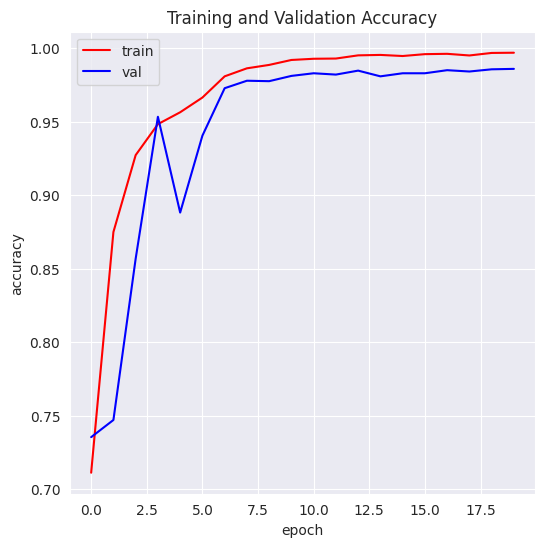

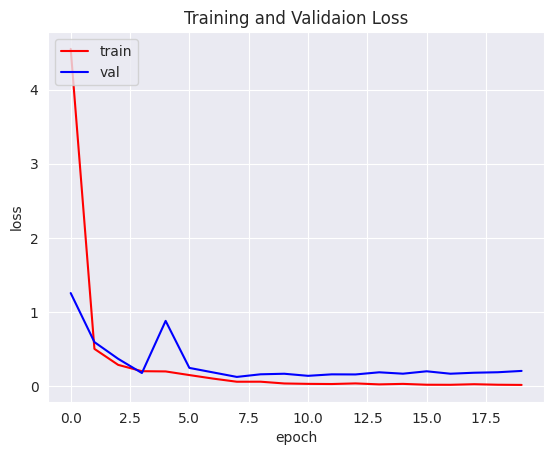

In [22]:
import seaborn as sns
plt.figure(figsize=(6,6))
sns.set_style("darkgrid")

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

In [23]:
test_generator.reset()

y_pred = model.predict(test_generator,verbose=0)
y_pred = np.argmax(y_pred, axis=1)

y_true = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

# Print Classification Report
print("\n")
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)



              precision    recall  f1-score   support

         cat       0.99      0.99      0.99      1157
         dog       0.99      0.98      0.98      1102
        wild       0.98      0.99      0.98      1087

    accuracy                           0.99      3346
   macro avg       0.99      0.99      0.99      3346
weighted avg       0.99      0.99      0.99      3346



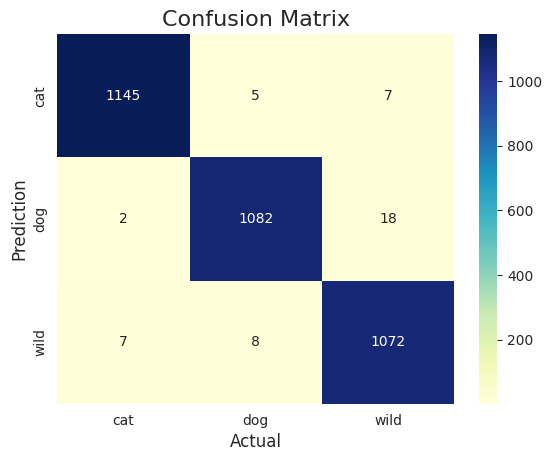

In [24]:
from sklearn.metrics import confusion_matrix, classification_report
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True,fmt='d', cmap='YlGnBu', xticklabels=np.array(class_labels), yticklabels=np.array(class_labels))
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

## Konversi Model

In [25]:
#saved model
!mkdir model
save_path = os.path.join("saved_model/")
tf.saved_model.save(model, save_path)
model.save('model/model.h5')
#saved tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model/model.tflite', 'wb') as f:
  f.write(tflite_model)

#saved tfjs
!pip install tensorflowjs
!tensorflowjs_converter --input_format=keras model/model.h5 tfjs_model

#zipping model for downloading
!zip -r model.zip model
!zip -r saved_model.zip saved_model
!zip -r tfjs_model.zip tfjs_model

Saved artifact at '/tmp/tmp0acjjs02'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_121')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  138226698126608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138226698129952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138226698130304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138226698133472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138226698131536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138226698131184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138226698141216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138226698141392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138226698244288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138226698246048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1382266982

## Inference (Optional)